In [33]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import skew, kurtosis, ks_2samp
from sklearn.metrics import adjusted_rand_score
from datetime import datetime


# Machine learning
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew, kurtosis
from yellowbrick.cluster import SilhouetteVisualizer

In [34]:
# Connexion à la base de données SQLite
db_connection = sqlite3.connect('olist.db')

In [35]:
def view_table(table, limit):
    query = f"""
        SELECT *
        FROM {table}
        LIMIT {limit}
    """
    return pd.read_sql_query(query, db_connection)

## Nombre de commandes

La table des commandes contient les identifiants de la commande et du client ainsi que le statut de livraison, qui peut être "livré" ou prendre d'autres valeurs avant que la commande ne soit livrée.

In [36]:
# Table orders, first 3 columns
view_table('orders', 5).iloc[:, :3]

,index,order_id,customer_id
0,0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d
1,1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef
2,2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089
3,3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82
4,4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c


Comptons le nombre de commandes quotidiennes dans l'ensemble de données en utilisant une commande SQL GROUP BY sur le timestamp de la commande et affichons les 5 premières lignes résultantes :


In [37]:
orders_per_day = """
SELECT
    DATE(order_purchase_timestamp) AS day,
    COUNT(*) AS order_count
FROM orders
GROUP BY day
"""

df = pd.read_sql_query(orders_per_day, db_connection)
df.head(5)

,day,order_count
0,2016-09-04,1
1,2016-09-05,1
2,2016-09-13,1
3,2016-09-15,1
4,2016-10-02,1


Dans l'output précédent, nous pouvons voir que les premiers jours contiennent très peu de commandes. Utilisons matplotlib pour visualiser la fréquence des commandes par jour :


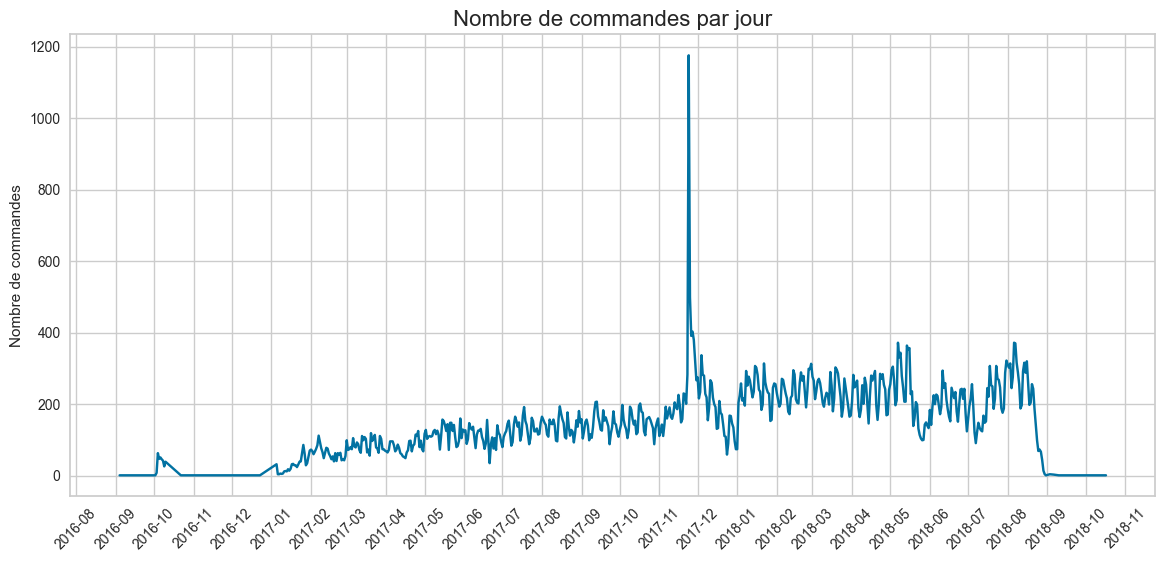

In [38]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Augmenter la taille de la police
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16

# Line plot
plt.figure(figsize=(14, 6))
plt.plot(pd.to_datetime(df['day']), df['order_count'])
plt.ylabel('Nombre de commandes')
plt.title('Nombre de commandes par jour')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.show()


Quelles sont les villes avec le plus de commandes dans l'ensemble de données ? Construisons une requête pour les 10 villes les plus importantes et visualisons le résultat. POur ce faire, nous allons joindre la table des commandes à la table des clients :

In [39]:
orders_per_city = """
SELECT
    COUNT(order_id) AS order_count,
    customers.customer_city as city
FROM 
    orders
JOIN
    customers on orders.customer_id = customers.customer_id
GROUP BY
    city
ORDER BY
    order_count DESC
LIMIT 10

"""

df = pd.read_sql_query(orders_per_city, db_connection)
df

,order_count,city
0,15540,sao paulo
1,6882,rio de janeiro
2,2773,belo horizonte
3,2131,brasilia
4,1521,curitiba
5,1444,campinas
6,1379,porto alegre
7,1245,salvador
8,1189,guarulhos
9,938,sao bernardo do campo


Traçons ces ville avec un graphique en barres horizontales. La fonction `barh` de matplotlib trace les données de bas en haut, donc nous devrons d'abord les inverser. Pour y parvenir en utilisant SQL, je vais utiliser la requête précédente comme sous-requête pour inverser l'ordre des résultats :


In [40]:
orders_per_city_reversed = f"""
SELECT *
FROM ({orders_per_city})
ORDER BY order_count
"""

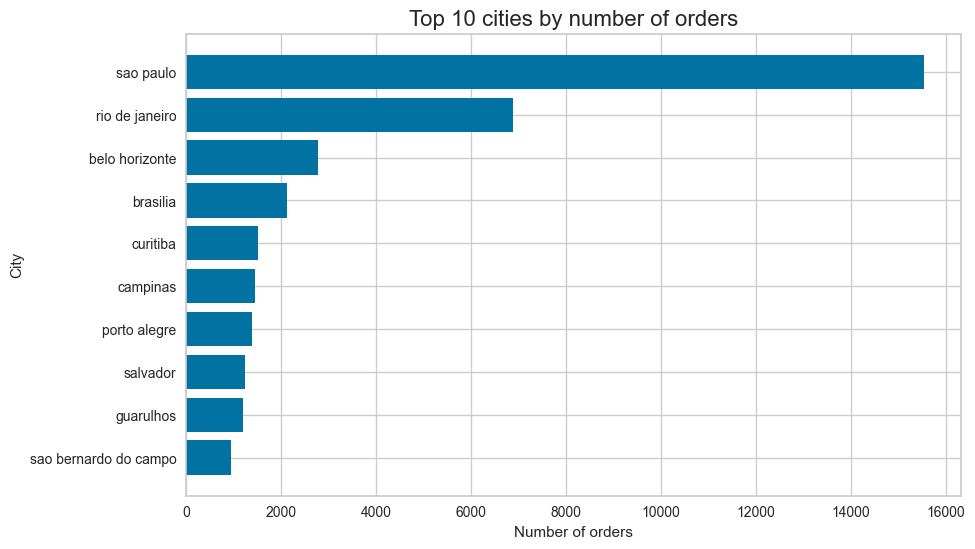

In [41]:
top_cities = pd.read_sql_query(orders_per_city_reversed, db_connection)

plt.figure(figsize=(10, 6))
plt.barh(top_cities['city'], top_cities['order_count'])
plt.xlabel('Number of orders')
plt.ylabel('City')
plt.title('Top 10 cities by number of orders')
plt.show()

Comme nous pouvons le voir, beaucoup plus de commandes sont passées à São Paulo et Rio de Janeiro que dans d'autres villes, comme on pourrait s'y attendre puisque ce sont également les plus grandes villes du Brésil.


Comment les commandes sont-elles réparties sur la semaine ? Y a-t-il plus de commandes passées le week-end ? Et en journée ? Les clients passent-ils plus de commandes le soir ? Nous pouvons répondre à ces questions en utilisant un diagramme à barres.

In [42]:
# Requête SQL pour regrouper les commandes par jour de la semaine
orders_per_day_of_week = """
SELECT 
    CAST(strftime('%w', order_purchase_timestamp) AS INTEGER) AS day_of_week,
    COUNT(order_id) AS order_count
FROM 
    orders
GROUP BY 
    day_of_week
ORDER BY 
    day_of_week;
"""

In [43]:
df

,order_count,city
0,15540,sao paulo
1,6882,rio de janeiro
2,2773,belo horizonte
3,2131,brasilia
4,1521,curitiba
5,1444,campinas
6,1379,porto alegre
7,1245,salvador
8,1189,guarulhos
9,938,sao bernardo do campo


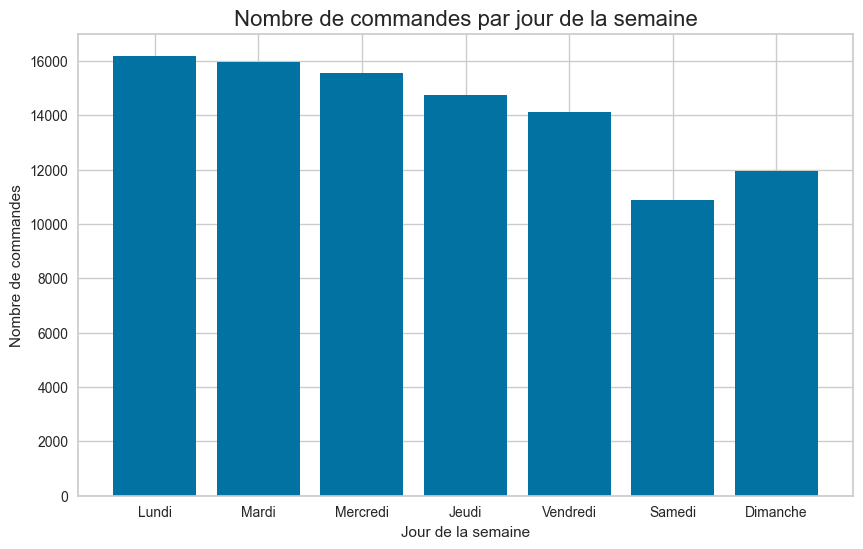

In [44]:
df = pd.read_sql_query(orders_per_day_of_week, db_connection)
df['day_of_week'] = df['day_of_week'].replace(0, 7)
df = df.sort_values(by=["day_of_week"])

# Associez l'entier du jour de la semaine aux noms de jour réels
day_names = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']


# Tracé du graphique
plt.figure(figsize=(10, 6))
plt.bar(df['day_of_week'].map(lambda x: day_names[int(x)-1]), df['order_count'])
plt.xlabel('Jour de la semaine')
plt.ylabel('Nombre de commandes')
plt.title('Nombre de commandes par jour de la semaine')
plt.show()

Le graphique représente le nombre de commandes par jour de la semaine. Voici l'interprétation des résultats observés:

1. **Lundi**: Le lundi enregistre le plus grand nombre de commandes de toute la semaine. Cela pourrait être dû au fait que les clients planifient et passent leurs commandes pour la semaine à venir après le week-end.

2. **Mardi à samedi**: Le nombre de commandes diminue régulièrement du mardi au samedi. Cela pourrait indiquer que les clients passent moins de commandes à mesure que la semaine avance, probablement parce qu'ils ont déjà effectué leurs principaux achats au début de la semaine.

3. **Dimanche**: Il y a une légère hausse du nombre de commandes le dimanche comparé au samedi. Cette augmentation pourrait être due à des achats de dernière minute ou à des préparations pour la semaine suivante.

## Prix des commandes

Quelle est la valeur moyenne d'une commande ? Olist gère-t-il des transactions d'articles de très faible ou de très haute valeur ? Avant de tenter de répondre à ces questions, examinons la table `order_items`. Cette table contient divers identifiants ainsi que le prix et le coût d'expédition des articles de la commande. La devise est le real brésilien :

In [45]:
# Table order_items, first 4 columns
view_table('order_items', 5).iloc[:, :4]

,index,order_id,order_item_id,product_id
0,0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61
1,1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f
2,2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd
3,3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc
4,4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089


In [46]:
# Table order_items, last 2 columns
view_table('order_items', 5).iloc[:, 5:]

,shipping_limit_date,price,freight_value
0,2017-09-19 09:45:35,58.90,13.29
1,2017-05-03 11:05:13,239.90,19.93
2,2018-01-18 14:48:30,199.00,17.87
3,2018-08-15 10:10:18,12.99,12.79
4,2017-02-13 13:57:51,199.90,18.14


Répondons d'abord à notre première question : Quel est le prix moyen d'une commande, en considérant à la fois le coût des produits et celui de l'expédition ? Pour commencer, trouvons les commandes avec les coûts les plus bas et les plus élevés :

In [47]:
order_price_stats = """
SELECT
    MIN(order_price) AS min_order_price,
    ROUND(AVG(order_price), 2) AS avg_order_price,
    MAX(order_price) AS max_order_price
FROM (
    SELECT
        orders.order_id,
        SUM(order_items.price + order_items.freight_value) AS order_price
    FROM orders
        JOIN order_items USING (order_id)
    GROUP BY orders.order_id
)
"""

pd.read_sql_query(order_price_stats, db_connection)

,min_order_price,avg_order_price,max_order_price
0,9.59,160.58,13664.08


Le prix moyen d'une commande est de 160,58 BRL, ce qui correspond environ au coût d'une paire de chaussures de sport en 2017 au Brésil. Comme nous pouvons le voir, la commande la plus chère est de 13 664,08 BRL, soit presque 100 fois la moyenne, ce qui signifie que nous avons probablement une distribution asymétrique à droite, où la plupart des commandes ont un coût faible mais certaines commandes ont un coût très élevé. Voyons la variation des prix, cette fois en séparant le coût des produits et le coût de l'expédition. Pour commencer, agrégeons le coût des produits et le coût de l'expédition pour chaque commande :

In [48]:
order_product_and_shipping_costs = """
SELECT
    orders.order_id,
    SUM(price) AS product_cost,
    SUM(freight_value) AS shipping_cost
FROM
    orders
    JOIN order_items USING (order_id)
WHERE order_status = 'delivered'
GROUP BY orders.order_id
"""

df = pd.read_sql_query(order_product_and_shipping_costs, db_connection)
df

,order_id,product_cost,shipping_cost
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,18.14
...,...,...,...
96473,fffc94f6ce00a00581880bf54a75a037,299.99,43.41
96474,fffcd46ef2263f404302a634eb57f7eb,350.00,36.53
96475,fffce4705a9662cd70adb13d4a31832d,99.90,16.95
96476,fffe18544ffabc95dfada21779c9644f,55.99,8.72


Traçons un histogramme de chaque coût. Étant donné que le coût peut prendre une large gamme de valeurs mais que la plupart des commandes ont un coût faible, je limiterai les axes x de chaque graphique à 500 reals et 80 reals respectivement pour mettre en évidence la distribution des valeurs les plus courantes :

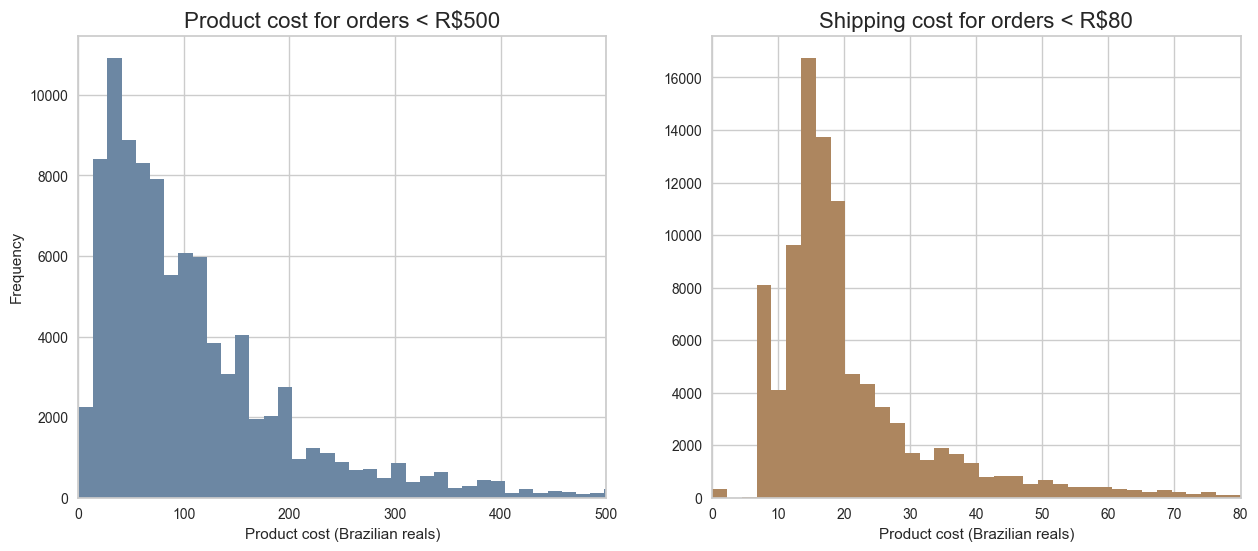

In [49]:
plt.figure(figsize=(15, 6))
# Histogram for total product cost
plt.subplot(1, 2, 1)
plt.hist(df['product_cost'], bins=1000, color='#6c87a3')
plt.title('Product cost for orders < R$500')
plt.xlabel('Product cost (Brazilian reals)')
plt.ylabel('Frequency')
plt.xlim([0, 500])
# Histogram for total shipping cost
plt.subplot(1, 2, 2)
plt.hist(df['shipping_cost'], bins=800, color='#ad865f')
plt.title('Shipping cost for orders < R$80')
plt.xlabel('Product cost (Brazilian reals)')
plt.xlim([0, 80])
plt.show()

La valeur des produits dans une commande peut varier considérablement, allant de très faible à très élevée, bien que la plupart des commandes contiennent des produits dont le coût total est inférieur à 200 reals.

Le coût de livraison est généralement compris entre 7 et 20 reals, et rarement en dessous, mais il peut également prendre une large gamme de valeurs beaucoup plus élevées.

## Notes des commandes

Notre base de données comprend également une table "order_reviews". Les utilisateurs peuvent attribuer une note à une commande de 1 à 5 et rédiger un commentaire sur la commande. Voyons les colonnes que nous utiliserons dans notre analyse :

In [50]:
view_table('order_reviews', 5).iloc[:, [2, 3, 4]]

,order_id,review_score,review_comment_title
0,73fc7af87114b39712e6da79b0a377eb,4,None
1,a548910a1c6147796b98fdf73dbeba33,5,None
2,f9e4b658b201a9f2ecdecbb34bed034b,5,None
3,658677c97b385a9be170737859d3511b,5,None
4,8e6bfb81e283fa7e4f11123a3fb894f1,5,None


Comptons combien il y a de commandes pour chaque score :

In [51]:
review_score_count = """
SELECT
    review_score,
    COUNT(*) AS count
FROM order_reviews
GROUP BY review_score
"""
df = pd.read_sql_query(review_score_count, db_connection)
df

,review_score,count
0,1,11424
1,2,3151
2,3,8179
3,4,19142
4,5,57328


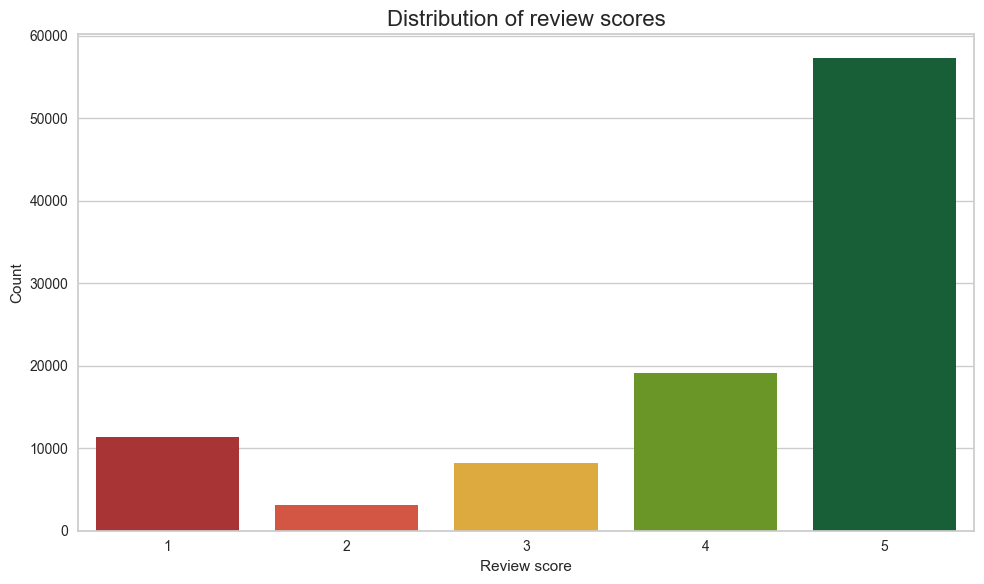

In [52]:
plt.figure(figsize=(10,6))
colors = ['#BC2023', '#EB442C', '#F8B324', '#6da814', '#0C6B37']
sns.barplot(x='review_score', y='count', data=df, hue='review_score', palette=colors, dodge=False)
plt.title('Distribution of review scores')
plt.xlabel('Review score')
plt.ylabel('Count')
plt.legend().remove()
plt.tight_layout()
plt.show()

Nous pouvons voir que la plupart des scores de révision sont très positifs, mais il y a aussi un nombre considérable de clients insatisfaits.

## Préparation des données pour le clustering

### Introduction

Dans cette analyse, nous allons lire les données de différentes tables provenant de notre base de données. Ces tables contiennent des informations sur les produits, les commandes, les articles de commande, les paiements de commande, les clients, les vendeurs et les avis de commande. Nous commencerons par charger ces tables dans des DataFrames.

In [53]:
tables = ['products', 'orders', 'order_items', 'order_pymts', 'customers', 'sellers', 'order_reviews']

### Lecture et affichage des premières lignes de chaque table

Nous lisons chaque table de la base de données dans un DataFrame et affichons les premières lignes pour vérifier la structure des données.

In [54]:
from IPython.display import display

# Liste des tables à lire
tables = ['products', 'orders', 'order_items', 'order_pymts', 'customers', 'sellers', 'order_reviews']

# Création des DataFrames pour chaque table
products_df = pd.read_sql_query("SELECT * FROM products", db_connection)
orders_df = pd.read_sql_query("SELECT * FROM orders", db_connection)
order_items_df = pd.read_sql_query("SELECT * FROM order_items", db_connection)
order_pymts_df = pd.read_sql_query("SELECT * FROM order_pymts", db_connection)
customers_df = pd.read_sql_query("SELECT * FROM customers", db_connection)
sellers_df = pd.read_sql_query("SELECT * FROM sellers", db_connection)
order_reviews_df = pd.read_sql_query("SELECT * FROM order_reviews", db_connection)

from IPython.display import display

# Affichage des premières lignes de chaque DataFrame
print("Products DataFrame")
display(products_df.head())

print("Orders DataFrame:")
display(orders_df.head())

print("Order Items DataFrame:")
display(order_items_df.head())

print("Order Payments DataFrame:")
display(order_pymts_df.head())

print("Customers DataFrame:")
display(customers_df.head())

print("Sellers DataFrame:")
display(sellers_df.head())

print("Order Reviews DataFrame:")
display(order_reviews_df.head())


Products DataFrame


,index,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


Orders DataFrame:


,index,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


Order Items DataFrame:


,index,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


Order Payments DataFrame:


,index,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


Customers DataFrame:


,index,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


Sellers DataFrame:


,index,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


Order Reviews DataFrame:


,index,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,None,None,2018-01-18 00:00:00,2018-01-18 21:46:59
1,1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,None,None,2018-03-10 00:00:00,2018-03-11 03:05:13
2,2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,None,None,2018-02-17 00:00:00,2018-02-18 14:36:24
3,3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,None,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,None,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [55]:
len(orders_df['customer_id'].unique())

99441

In [56]:
# Requête pour obtenir les noms de toutes les tables
query = "SELECT name FROM sqlite_master WHERE type='table';"

# Exécution de la requête
tables = pd.read_sql_query(query, db_connection)

# Affichage des noms de tables
print(tables)

            name
0      customers
1         geoloc
2    order_items
3    order_pymts
4  order_reviews
5         orders
6       products
7        sellers
8    translation


In [57]:
# Chemin vers votre base de données SQLite
db_path = 'olist.db'

# Connexion à la base de données SQLite
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Fonction pour récupérer les colonnes d'une table spécifique
def get_table_columns(cursor, table_name):
    cursor.execute(f"PRAGMA table_info('{table_name}')")
    columns = cursor.fetchall()
    column_names = [col[1] for col in columns]  # Le nom de la colonne est en deuxième position dans chaque tuple retourné
    return column_names

# Liste des tables à inspecter
tables = ['customers', 'geoloc', 'order_items', 'order_pymts', 'order_reviews', 'orders', 'products', 'sellers', 'translation']

# Récupération des colonnes pour chaque table et affichage des résultats
for table in tables:
    columns = get_table_columns(cursor, table)
    print(f"Table: {table}")
    print(f"Colonnes: {columns}")
    print("\n")

# Fermeture de la connexion à la base de données
conn.close()



Table: customers
Colonnes: ['index', 'customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']


Table: geoloc
Colonnes: ['index', 'geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng', 'geolocation_city', 'geolocation_state']


Table: order_items
Colonnes: ['index', 'order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']


Table: order_pymts
Colonnes: ['index', 'order_id', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value']


Table: order_reviews
Colonnes: ['index', 'review_id', 'order_id', 'review_score', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp']


Table: orders
Colonnes: ['index', 'order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']


Table: products
Colonnes: 

### Fusion des DataFrames

Nous fusionnons les DataFrames les plus pertinents (`orders_df`, `order_payments_df`, `order_items_df`) pour l'analyse initiale.

In [58]:
### RFM

# Fusionner orders_df avec order_pymts_df
merged_df = pd.merge(orders_df, customers_df, how="left", on="customer_id", suffixes=('_orders', '_customers'))

# Fusionner orders_df avec order_pymts_df
merged_df = pd.merge(merged_df, order_items_df, how="left", on="order_id", suffixes=('_orders', '_customers'))

colums_to_keep = [
    'order_id',
    'order_status',
    'order_purchase_timestamp',
    'customer_unique_id',
    'customer_state',
    'price',
    'freight_value',
]

merged_df = merged_df[colums_to_keep]

# On ne garde que les lignes dont le price n'est pas (~) nul 
orders_with_price = merged_df.loc[~merged_df['price'].isnull()]

# Afficher les premières lignes du DataFrame fusionné
print("Premières lignes du DataFrame fusionné et nettoyé (merged_df) :")
display(orders_with_price.head())

print(len(orders_with_price))

Premières lignes du DataFrame fusionné et nettoyé (merged_df) :


,order_id,order_status,order_purchase_timestamp,customer_unique_id,customer_state,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,SP,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,BA,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8,GO,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,delivered,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977,RN,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,delivered,2018-02-13 21:18:39,72632f0f9dd73dfee390c9b22eb56dd6,SP,19.90,8.72


112650


In [59]:
### REVIEW SCORE

# On cherche à obtenir un DataFrame avec deux colonnes : customer_unique_id et review_score
merged_df = pd.merge(orders_df, customers_df, how='left', on='customer_id', suffixes=('_orders', '_customers'))

merged_df = pd.merge(merged_df, order_reviews_df, how='left', on='order_id', suffixes=('_merged', '_reviews'))

# Garder les colonnes utiles
colums_to_keep = [
    'order_id',
    'customer_unique_id',
    'review_score',
]

merged_df = merged_df[colums_to_keep]

# On ne garde que les lignes dont le review score n'est pas (~) nul
orders_with_review_score = merged_df.loc[~merged_df['review_score'].isnull()]

# Afficher les premières lignes du DataFrame fusionné
print("Premières lignes du DataFrame fusionné et nettoyé et groupé :")
display(orders_with_review_score.head())

print(len(orders_with_review_score))

Premières lignes du DataFrame fusionné et nettoyé et groupé :


,order_id,customer_unique_id,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,4.0
1,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,4.0
2,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8,5.0
3,949d5b44dbf5de918fe9c16f97b45f8a,7c142cf63193a1473d2e66489a9ae977,5.0
4,ad21c59c0840e6cb83a9ceb5573f8159,72632f0f9dd73dfee390c9b22eb56dd6,5.0


99224


### Analyse de la distribution de la valeur des transactions
Nous générons un histogramme du logarithme naturel de la colonne `amount` pour examiner la distribution de la valeur des produits commandés.


Text(0.5, 0, '')

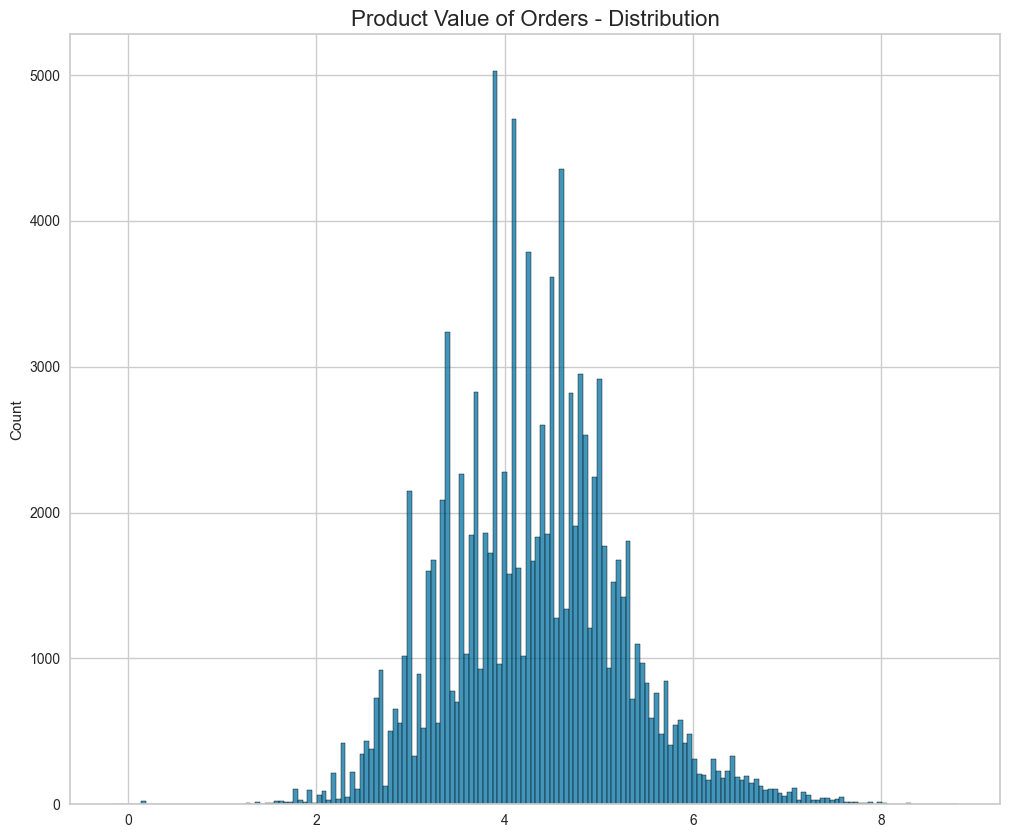

In [60]:
plt.figure(figsize=(12,10))
sns.histplot(np.log(orders_with_price['price']))
plt.title("Product Value of Orders - Distribution")
plt.xlabel("")

**Calcul de la skewness et de la kurtosis :**

Nous calculons et affichons la skewness et la kurtosis pour évaluer la symétrie et la forme de la distribution des valeurs des transactions.


In [61]:
print("Skewness of the transaction value:", skew(np.log(orders_with_price['price'])))
print("Excess Kurtosis of the transaction value:", kurtosis(np.log(orders_with_price['price'])))

Skewness of the transaction value: 0.23909367248174712
Excess Kurtosis of the transaction value: 0.4700676516642437


Les valeurs de la skewness (asymétrie) et de l'excès de kurtosis fournissent des indications sur la forme et les caractéristiques de la distribution des valeurs de transaction :

- Skewness (Asymétrie) : Avec une valeur de skewness de 0.2677, la distribution montre une légère asymétrie vers la droite. Cependant, elle reste globalement relativement symétrique.
  
- Excès de kurtosis : La valeur d'excès de kurtosis de 0.4101 indique que la distribution est légèrement plus pointue par rapport à une distribution normale, mais elle reste assez proche d'une distribution normale standard.

En résumé, les valeurs de transaction présentent une distribution légèrement asymétrique vers la droite et légèrement plus pointue qu'une distribution normale. Ces valeurs suggèrent que la distribution s'écarte légèrement de la normalité, mais reste relativement bien adaptée à des fins d'analyse statistique et de modélisation.

In [62]:
# Calculer le nombre de valeurs manquantes par colonne
missing_values = orders_with_price.isnull().sum()

# Afficher les colonnes avec des valeurs manquantes (si nécessaire)
print("Colonnes avec des valeurs manquantes :")
print(missing_values[missing_values > 0])

# Afficher le nombre total de valeurs manquantes par colonne
print("\nNombre total de valeurs manquantes par colonne :")
print(missing_values)

Colonnes avec des valeurs manquantes :
Series([], dtype: int64)

Nombre total de valeurs manquantes par colonne :
order_id                    0
order_status                0
order_purchase_timestamp    0
customer_unique_id          0
customer_state              0
price                       0
freight_value               0
dtype: int64


### Analyse des Outliers dans les Données Client

Dans cette cellule, nous allons analyser la distribution des outliers dans notre jeu de données clients en utilisant un boxplot. Nous allons nous concentrer sur les colonnes `price` et `freight_value` pour chaque `customer_id`. Pour ce faire, nous allons utiliser la bibliothèque Seaborn pour créer un boxplot qui nous permettra de visualiser la répartition des valeurs extrêmes (outliers) pour ces variables.

Voici les étapes que nous allons suivre :
1. Sélectionner les colonnes `customer_id`, `price`, et `freight_value` de notre DataFrame `order_payment_product`.
2. Configurer la taille de la figure pour notre boxplot.
3. Créer le boxplot avec les paramètres souhaités (orientation verticale, palette de couleurs, etc.).
4. Ajouter un titre et des labels pour les axes pour une meilleure compréhension du graphique.

Les outliers sont des observations qui se situent bien au-delà de la majorité des données, et leur identification est cruciale pour une analyse approfondie et fiable des données.



Text(0.5, 0, 'Attributes')

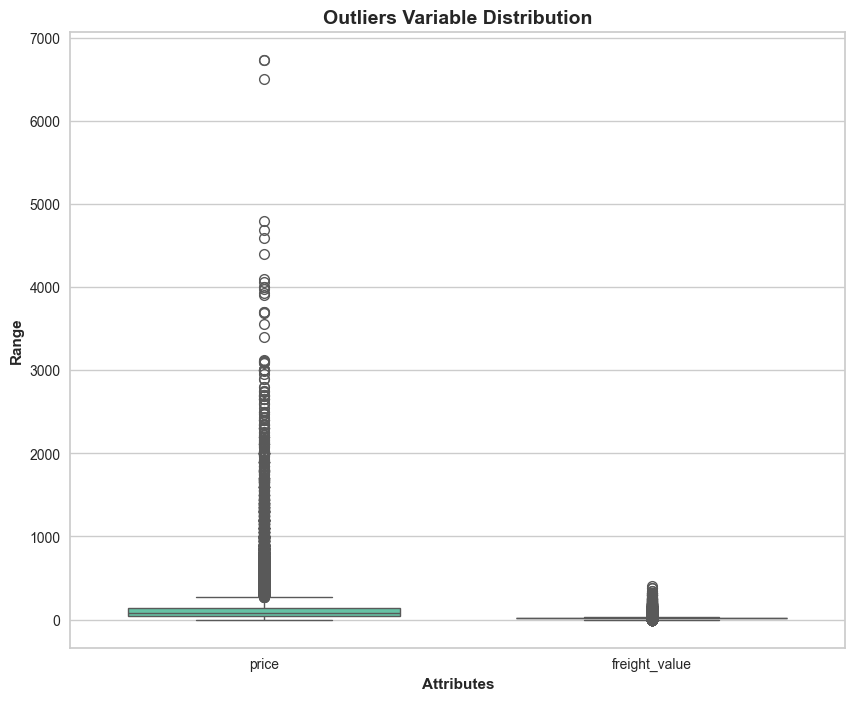

In [63]:
# Lets define our customer by age and amount spended(price)
visualisation_df = orders_with_price[['customer_unique_id','price','freight_value']]

# Set the default figure size for the boxplot
plt.rcParams['figure.figsize'] = [10,8]

# Create a boxplot using Seaborn
sns.boxplot(data = visualisation_df, orient="v", palette="Set2", whis=1.5, saturation=1, width=0.7)

# Set the title of the boxplot
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')

# Label the y-axis of the boxplot
plt.ylabel("Range", fontweight = 'bold')

# Label the x-axis of the boxplot
plt.xlabel("Attributes", fontweight = 'bold')

Après avoir créé le boxplot, nous avons remarqué des outliers dans la variable `price`. Les valeurs atteignent environ 7000. Par conséquent, nous devons les traiter.

In [64]:
# Fonction pour supprimer les outliers
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.05)
    Q3 = df[column].quantile(0.95)
    IQR = Q3 - Q1
    df_filtered = df[(df[column] >= Q1 - 1.5*IQR) & (df[column] <= Q3 + 1.5*IQR)]
    return df_filtered

# Appliquer la fonction pour Amount et age
orders_with_price_cleaned = remove_outliers(orders_with_price, 'price')

In [65]:
# Trier le DataFrame par les valeurs de la colonne 'amount' par ordre croissant
orders_with_price_cleaned.sort_values(by='price', inplace=True)

# Réinitialiser l'index du DataFrame après le tri, en supprimant l'ancien index
orders_with_price_cleaned = orders_with_price_cleaned.reset_index(drop=True)

orders_with_price_cleaned.to_csv('orders_with_price_cleaned.csv', index=False)

C:\Users\Mathieu Bosse\AppData\Local\Temp\ipykernel_48632\946540422.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_with_price_cleaned.sort_values(by='price', inplace=True)


**Créons un autre boxplot pour vérifier la distribution sans les outliers**

Nous allons créer un nouveau boxplot pour vérifier comment la distribution des variables `amount` et `age` change après avoir supprimé les outliers. Cela nous permettra de mieux comprendre la distribution des données sans les valeurs extrêmes.


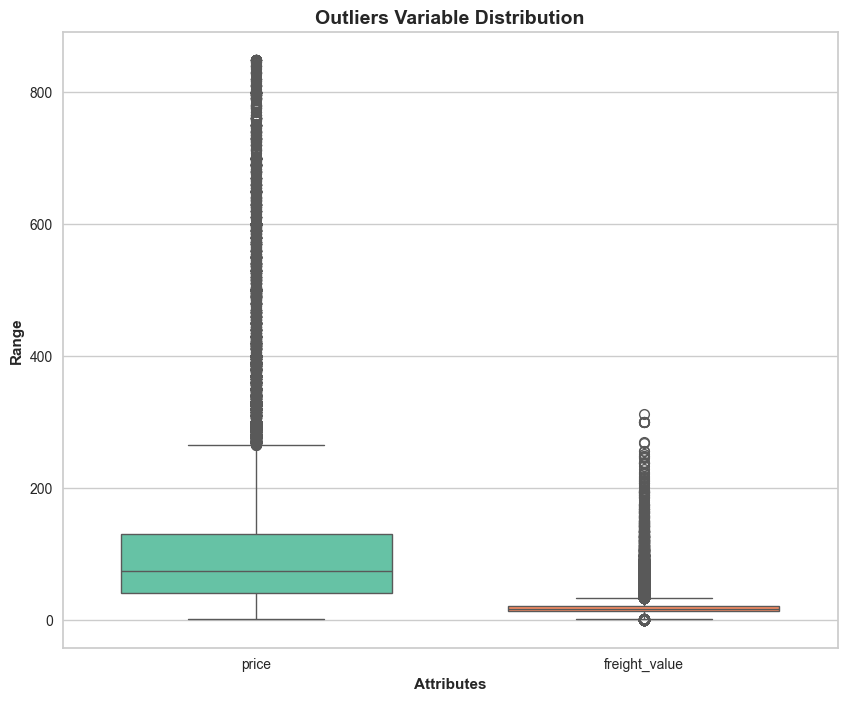

In [66]:
# Créons un autre boxplot pour vérifier la distribution sans les outliers
plt.rcParams['figure.figsize'] = [10,8]

sns.boxplot(data = orders_with_price_cleaned, orient="v", palette="Set2", whis=1.5, saturation=1, width=0.7)

plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

plt.show()

Des outliers sont toujours observés dans le graphique, mais ils sont moins extrêmes que ceux présentés dans le graphique précédent. Nous avons décidé de les conserver afin de conserver la diversité des données. Cette diversité peut enrichir les analyses et les modèles en capturant une gamme plus large de scénarios et de résultats possibles.


**Tri du DataFrame par les valeurs de la colonne `price` et réinitialisation de l'index**

Nous allons trier le DataFrame par les valeurs de la colonne `price` par ordre croissant. Ensuite, nous allons réinitialiser l'index du DataFrame après le tri, en supprimant l'ancien index. Cela permettra d'avoir un DataFrame propre et ordonné, facilitant les analyses ultérieures.


In [70]:
# Selectionner les colonnes 'customer_unique_id', 'price', et 'freight_value' de 'orders_with_price_cleaned'
price_and_freight_value_df_for_clustering = orders_with_price_cleaned[['customer_unique_id', 'price', 'freight_value']]

# Trier le DataFrame par les valeurs de la colonne 'price' par ordre croissant
price_and_freight_value_df_for_clustering.sort_values(by='price', inplace=True)

# Réinitialiser l'index du DataFrame après le tri, en sup


C:\Users\Mathieu Bosse\AppData\Local\Temp\ipykernel_48632\856730818.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_and_freight_value_df_for_clustering.sort_values(by='price', inplace=True)


In [71]:
# Sauvegarder dans un fichier CSV dans le répertoire de travail actuel
price_and_freight_value_df_for_clustering.to_csv('price_and_freight_value_df_for_clustering.csv', index=False)

## RFM Feature Engineering

### Calcul de la Segmentation RFM en SQL

La segmentation RFM (Récence, Fréquence, Montant) est une méthode couramment utilisée en marketing pour analyser le comportement des clients. Cette cellule Python exécute une requête SQL pour calculer les scores RFM des clients d'Olist. Voici les détails de la requête :

- **Récence**: Nombre de jours depuis la dernière commande d'un client.
- **Fréquence**: Nombre total de commandes passées par un client.
- **Montant**: Somme totale dépensée par un client sur toutes ses commandes.

La requête SQL regroupe les données par `customer_id`, sélectionne uniquement les commandes dont le statut est 'delivered', et calcule les valeurs RFM pour chaque client. Les résultats sont ensuite chargés dans un DataFrame pandas pour une analyse ultérieure.

In [72]:
rfm = """

WITH orders_with_unique_customer_id AS (
    SELECT
        c.customer_unique_id,
        o.order_purchase_timestamp,
        o.order_id,
        o.order_status
    FROM
        orders o
    LEFT JOIN
        customers c ON o.customer_id = c.customer_id
)

SELECT
    o.customer_unique_id,
    (JulianDay('now') - JulianDay(MAX(o.order_purchase_timestamp))) AS recency,
    COUNT(DISTINCT o.order_id) AS frequency,
    SUM(oi.price) AS monetary
FROM
    orders_with_unique_customer_id o
JOIN
    order_items oi ON o.order_id = oi.order_id
WHERE
    o.order_status = 'delivered'
GROUP BY
    o.customer_unique_id
ORDER BY
    frequency DESC;

"""

df = pd.read_sql_query(rfm, db_connection)
df.head(5)


,customer_unique_id,recency,frequency,monetary
0,8d50f5eadf50201ccdcedfb9e2ac8455,2162.710075,15,714.63
1,3e43e6105506432c953e165fb2acf44c,2336.736314,9,1000.85
2,ca77025e7201e3b30c44b472ff346268,2243.026707,7,806.61
3,6469f99c1f9dfae7733b25662e7f1782,2216.481511,7,664.20
4,1b6c7548a2a1f9037c1fd3ddfed95f33,2349.954682,7,809.21


**Détails du DataFrame RFM**

Cette cellule utilise la méthode `info()` de pandas pour obtenir un résumé du DataFrame contenant les scores RFM des clients. Cela inclut des informations sur le nombre d'entrées, les noms de colonnes, les types de données, et la mémoire utilisée. Cette étape est essentielle pour vérifier que les données ont été correctement chargées et pour comprendre la structure des données avant de procéder à des analyses plus approfondies.


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93358 entries, 0 to 93357
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  93358 non-null  object 
 1   recency             93358 non-null  float64
 2   frequency           93358 non-null  int64  
 3   monetary            93358 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 2.8+ MB


**Sauvegarde des Données RFM**

Cette cellule sauvegarde le DataFrame contenant les scores RFM dans un fichier CSV nommé `rfm.csv` dans le répertoire de travail actuel. Cela permet de conserver les résultats de l'analyse RFM pour une utilisation ou une analyse ultérieure.


In [74]:
# Sauvegarder dans un fichier CSV dans le répertoire de travail actuel
df.to_csv('rfm.csv', index=False)

### Calcul des Données RFM avec Python

Cette cellule utilise Python pour calculer les scores RFM (Récence, Fréquence, Montant) sur un DataFrame nettoyé. Les étapes incluent :

- Conversion des colonnes de dates en format datetime.
- Filtrage des commandes livrées.
- Calcul des valeurs RFM :
  - **Récence**: Nombre de jours depuis la dernière commande.
  - **Fréquence**: Nombre total de commandes uniques.
  - **Montant**: Somme totale dépensée.
- Renommage des colonnes et affichage des 5 premières lignes du DataFrame.

Les résultats sont ensuite sauvegardés dans un fichier CSV `rfm_python.csv`.

Utilisation de `info()` pour obtenir un aperçu des caractéristiques du DataFrame `rfm_python`.

In [76]:
# On ne garde que les order dont le statut est "delivered"
orders_with_price_cleaned = orders_with_price_cleaned.loc[orders_with_price_cleaned['order_status']=="delivered"]

# Calculate RFM values
orders_with_price_cleaned['order_purchase_timestamp'] = pd.to_datetime(orders_with_price_cleaned['order_purchase_timestamp'])
reference_date = orders_with_price_cleaned['order_purchase_timestamp'].max()

rfm_python = (
    orders_with_price_cleaned.groupby(by="customer_unique_id")
    .agg(
        recency=('order_purchase_timestamp', lambda x: (reference_date - x.max()).days),
        frequency=('order_id', 'count'),
        monetary=('price', 'sum')
    )
    .reset_index()
)

# Afficher les premières lignes du DataFrame fusionné
print("Premières lignes du DataFrame fusionné et nettoyé (rfm_python) :")
display(rfm_python.head())

print(len(rfm_python))

rfm_python.to_csv('rfm_python.csv', index=False)

C:\Users\Mathieu Bosse\AppData\Local\Temp\ipykernel_48632\3979418518.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_with_price_cleaned['order_purchase_timestamp'] = pd.to_datetime(orders_with_price_cleaned['order_purchase_timestamp'])


Premières lignes du DataFrame fusionné et nettoyé (rfm_python) :


,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,18.90
2,0000f46a3911fa3c0805444483337064,536,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,320,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,287,1,180.00


92247


In [77]:
rfm_python.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92247 entries, 0 to 92246
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  92247 non-null  object 
 1   recency             92247 non-null  int64  
 2   frequency           92247 non-null  int64  
 3   monetary            92247 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 2.8+ MB


### Sélection de la variable review_score pour l'Analyse RFM avec Variable Numérique

Cette cellule calcule la moyenne des scores d'avis pour chaque client afin d'ajouter une variable numérique pour une analyse future avec k-means en complément des données RFM. Les étapes incluent :

- Calcul de la moyenne des scores d'avis par client.
- Renommage des colonnes.
- Affichage des premières lignes du DataFrame.
- Sauvegarde du DataFrame dans un fichier CSV pour une utilisation ultérieure.


In [92]:
# Calcul review score moyen
orders_with_review_score = orders_with_review_score.drop_duplicates(subset=["order_id"])

customer_unique_id_with_average_review_score_df = (
    orders_with_review_score.groupby(by="customer_unique_id")
    .agg({'review_score':'mean'})
    .reset_index()
)

customer_unique_id_with_average_review_score_df.to_csv("average_review_scores_df.csv", index=False)

display(customer_unique_id_with_average_review_score_df)

,customer_unique_id,review_score
0,0000366f3b9a7992bf8c76cfdf3221e2,5.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,4.0
2,0000f46a3911fa3c0805444483337064,3.0
3,0000f6ccb0745a6a4b88665a16c9f078,4.0
4,0004aac84e0df4da2b147fca70cf8255,5.0
...,...,...
95375,fffcf5a5ff07b0908bd4e2dbc735a684,5.0
95376,fffea47cd6d3cc0a88bd621562a9d061,4.0
95377,ffff371b4d645b6ecea244b27531430a,5.0
95378,ffff5962728ec6157033ef9805bacc48,5.0


Ici, filtrage les données du DataFrame `average_review_scores_df` pour ne conserver que les informations relatives au client ayant l'identifiant `270c23a11d024a44c896d1894b261a83`. Cette étape est cruciale pour vérifier la cohérence et l'intégrité des données spécifiques à chaque client, y compris les scores RFM et la moyenne des scores d'avis.


### Sélection de la colonne customer_state pour l'Analyse RFM avec Variable Catégorielle

Sélection de la colonne 'customer_state' dans le DataFrame `orders_merged_cleaned` pour une analyse future avec k-means, intégrant une variable catégorielle supplémentaire en plus des scores RFM.

In [ ]:
# Sélectionner les colonnes 'customer_id' et 'customer_state' dans orders_merged_cleaned
customer_state_df = orders_merged_cleaned[['customer_unique_id', 'customer_state']]

# Afficher les premières lignes du DataFrame résultant
display(customer_state_df.head())

customer_state_df.to_csv("customer_state_df.csv", index=False)

,customer_id,customer_state
0,161b6d415e8b3413c6609c70cf405b5a,SP
1,5af78bf1a82a2660d1e3fd78c645f58f,SP
2,9f9d249355f63c5c1216a82b802452c1,RJ
3,fc3d1daec319d62d49bfb5e1f83123e9,SP
4,fc3d1daec319d62d49bfb5e1f83123e9,SP


In [84]:
# Sélectionner les colonnes 'customer_id' et 'customer_state' dans orders_merged_cleaned
customers_state_df = orders_with_price_cleaned[['customer_unique_id', 'customer_state']]

customers_state_df = customers_state_df.drop_duplicates()

customers_state_df

,customer_unique_id,customer_state
0,f006d7920bd71c252f61ec355eb50dcb,SP
1,d80730c15c647bc8f2ad77c908ba5ca9,SP
2,b38211bd797f4fdd81a98b9d1754b606,RJ
3,4546caea018ad8c692964e3382debd19,SP
23,317cfc692e3f86c45c95697c61c853a6,SP
...,...,...
111410,45d4fbed807eacc8d7d5b99247a16a55,MG
111411,c1af67e73acdb33638179ec6cb0fbd3c,RJ
111414,9835d36e16d2102ba67f493776a52e96,GO
111415,4fdc62ec0c92703fde661756400e686d,MG


In [86]:
customers_state_df.nunique()

customer_unique_id    92247
customer_state           27
dtype: int64

In [87]:
# Group by 'customer_unique_id' and count unique 'customer_state' values
state_counts = customers_state_df.groupby('customer_unique_id')['customer_state'].nunique()

# Filter to include only those with more than one distinct 'customer_state'
multiple_states = state_counts[state_counts > 1]

# Get the number of customer_unique_id with more than one distinct customer_state
num_customers_multiple_states = multiple_states.count()

# Print the result
print(f"Number of customer_unique_id with more than one distinct customer_state: {num_customers_multiple_states}")

Number of customer_unique_id with more than one distinct customer_state: 36


In [91]:
# Sort the DataFrame by customer_unique_id to maintain order (if needed)
customers_state_df.sort_values(by='customer_unique_id', inplace=True)

# Group by 'customer_unique_id' and get the first 'customer_state' for each
first_state_df = customers_state_df.groupby('customer_unique_id').first().reset_index()

display(first_state_df)

first_state_df.to_csv("customer_state_df.csv", index=False)

,customer_unique_id,customer_state
0,0000366f3b9a7992bf8c76cfdf3221e2,SP
1,0000b849f77a49e4a4ce2b2a4ca5be3f,SP
2,0000f46a3911fa3c0805444483337064,SC
3,0000f6ccb0745a6a4b88665a16c9f078,PA
4,0004aac84e0df4da2b147fca70cf8255,SP
...,...,...
92242,fffcf5a5ff07b0908bd4e2dbc735a684,PE
92243,fffea47cd6d3cc0a88bd621562a9d061,BA
92244,ffff371b4d645b6ecea244b27531430a,MT
92245,ffff5962728ec6157033ef9805bacc48,ES
